# Предварительный код

In [1]:
import numpy as np
import pandas as pd
import torch
import random
import os
import lightning as L

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# basic random seed
def seed_basic(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


# torch random seed
def seed_torch(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# basic + torch + lightning
def seed_everything(seed=42):
    seed_basic(seed)
    seed_torch(seed)
    L.seed_everything(seed)


seed_everything()

Seed set to 42


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Загрузка данных и модели

In [3]:
from datasets import load_dataset

dataset_train = load_dataset("deepmind/aqua_rat", split="train")
dataset_val = load_dataset("deepmind/aqua_rat", split="validation")
dataset_test = load_dataset("deepmind/aqua_rat", split="test")

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMultipleChoice

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
base_model = AutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")

2024-12-10 16:18:17.123825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 16:18:17.919215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def preprocess_function(examples):
    ans_len = len(examples["options"])
    first_sentences = []
    for q in examples['question']:
        for i in range(5):
            first_sentences.append(q)
    second_sentences = []
    for choice_list in examples['options']:
        for choice in choice_list:
            second_sentences.append(choice)
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True, padding = 'max_length')
    dic = {'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}
    return {k: [v[i : i + 5] for i in range(0, len(v), 5)] for k, v in tokenized_examples.items()}

In [7]:
def encode_labels(examples):
    label_map = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
    labels = []
    for example in examples["correct"]:
        labels.append(label_map[example])
    return {"labels": labels}
    
dataset_train = dataset_train.map(preprocess_function, batched=True)
dataset_train = dataset_train.map(encode_labels, batched=True)
dataset_val = dataset_val.map(preprocess_function, batched=True)
dataset_val = dataset_val.map(encode_labels, batched=True)
dataset_test = dataset_test.map(preprocess_function, batched=True)
dataset_test = dataset_test.map(encode_labels, batched=True)

In [8]:
dataset_train.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle = True)
dataset_val.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle = False)
dataset_test.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle = False)

# Тренировка

## LoRA

In [10]:
from peft import LoraConfig, TaskType

peft_config = LoraConfig(inference_mode=False, r=10, lora_alpha=32, lora_dropout=0.1)

In [11]:
from peft import get_peft_model

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 368,640 || all params: 109,851,649 || trainable%: 0.3356


### Кастомный Trainer

In [12]:
from torchmetrics.classification import BinaryAccuracy, Accuracy
class LModel(L.LightningModule):

    def __init__(
            self, model, lr=2e-4,
        ):
        super().__init__()
        self.model = model
        self.train_acc = Accuracy(task="multiclass", num_classes=5)
        self.valid_acc = Accuracy(task="multiclass", num_classes=5)
        self.test_acc = Accuracy(task="multiclass", num_classes=5)
        self.lr = lr
        self.automatic_optimization = True

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)
        self.train_acc.update((preds.detach()), y.detach())
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        return loss
        
    def on_train_epoch_end(self):
        self.log("Acc/train", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)
        self.valid_acc.update((preds.detach()), y.detach())
        self.log("loss/val", loss.detach().item())
        
    def on_validation_epoch_end(self):
        self.log("Acc/val", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()
        
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        preds = torch.nn.functional.softmax(logits, dim = 1)
        self.test_acc.update((preds.detach()), y.detach())
        
    def on_test_epoch_end(self):
        self.log("Acc/test", self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

In [13]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

def create_trainer(name, max_epochs = 10):
    checkpoint_callback = ModelCheckpoint(
    dirpath=f'../{name}',
    save_last=False,
    every_n_epochs=1,
    save_top_k=1,
    monitor="loss/val",
    filename=name,
    mode="min",
    )

    torch.set_float32_matmul_precision('medium')
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback],#EarlyStopping(monitor="loss/val", mode="min", patience = 5)
        num_sanity_val_steps=1,
        log_every_n_steps=5,
        logger=L.pytorch.loggers.CSVLogger(save_dir=f"../logs/", name = name),
    )
    return trainer

In [14]:
pl_model = LModel(model)
trainer = create_trainer("AQUA_lora", max_epochs = 5)
trainer.test(pl_model, dataloaders = test_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.21653543412685394    │
└───────────────────────────┴───────────────────────────┘

In [15]:
trainer.fit(
    model=pl_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PeftModel          | 109 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | valid_acc | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
368 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.407   Total estimated model params size (MB)
245       Modules in train mode
231       Modules in eval mode


Epoch 0: 100%|██████████| 1523/1523 [35:08<00:00,  0.72it/s, v_num=2, loss/train=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1523/1523 [35:23<00:00,  0.72it/s, v_num=2, loss/train=1.410, Acc/val=0.244, Acc/train=0.291]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1523/1523 [35:06<00:00,  0.72it/s, v_num=2, loss/train=1.430, Acc/val=0.248, Acc/train=0.355]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1523/1523 [35:06<00:00,  0.72it/s, v_num=2, loss/train=1.280, Acc/val=0.224, Acc/train=0.409]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1523/1523 [35:06<00:00,  0.72it/s, v_num=2, loss/train=1.210, Acc/val=0.244, Acc/train=0.457]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1523/1523 [35:08<00:00,  0.72it/s, v_num=2, loss/train=1.210, Acc/val=0.272, Acc/train=0.457]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1523/1523 [35:08<00:00,  0.72it/s, v_num=2, loss/train=1.210, Acc/val=0.272, Acc/train=0.457]


In [16]:
trainer.test(pl_model, dataloaders = test_dataloader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.29133859276771545    │
└───────────────────────────┴───────────────────────────┘

## RoseLoRA

In [ ]:
from src.rose_lora import SparseSVDLinear, RoseLoraModel
from peft import LoraConfig, TaskType

max_epochs = 5
peft_config = LoraConfig(inference_mode=False, r=10, lora_alpha=32, lora_dropout=0.1)
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

adaLora_wrapper = RoseLoraModel(base_model, peft_config, adapter_name="default", total_step = max_epochs*len(train_dataloader), sparsity=0.1)
roseLora_model = adaLora_wrapper


In [45]:
class LModelRoseLora(L.LightningModule):

    def __init__(
            self, model, lr=2e-4,
        ):
        super().__init__()
        self.model = model
        self.train_acc = Accuracy(task="multiclass", num_classes=5)
        self.valid_acc = Accuracy(task="multiclass", num_classes=5)
        self.test_acc = Accuracy(task="multiclass", num_classes=5)
        self.lr = lr
        self.automatic_optimization = False
        self.i_step = 0

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr = self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        
        #---Manual optimization block---
        opt = self.optimizers() 
        opt.zero_grad()
        loss = out.loss
        self.manual_backward(loss)
        opt.step()
        self.model.update_and_allocate(self.i_step) #Step RoseLoRA - в статье написано, что после шага градиента, так что делаю после opt.step()
        
        preds = torch.nn.functional.softmax(logits, dim = 1)
        self.train_acc.update((preds.detach()), y.detach())
        self.log("loss/train", loss.detach().item(), prog_bar=True)
        self.i_step += 1
        return loss
        
    def on_train_epoch_end(self):
        self.log("Acc/train", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        loss = out.loss
        preds = torch.nn.functional.softmax(logits, dim = 1)
        self.valid_acc.update((preds.detach()), y.detach())
        self.log("loss/val", loss.detach().item())
        
    def on_validation_epoch_end(self):
        self.log("Acc/val", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()
        
    def test_step(self, batch, batch_idx):
        y = batch['labels']
        out = self.model.forward(**batch)
        logits = out.logits
        preds = torch.nn.functional.softmax(logits, dim = 1)
        self.test_acc.update((preds.detach()), y.detach())
        
    def on_test_epoch_end(self):
        self.log("Acc/test", self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

In [46]:
pl_roseLora_model = LModelRoseLora(roseLora_model)
trainer = create_trainer("AQUA_roselora", max_epochs = max_epochs)
trainer.test(pl_roseLora_model, dataloaders = test_dataloader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:02<00:00,  3.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Acc/test          │    0.20866142213344574    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
trainer.fit(
    model=pl_roseLora_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | RoseLoraModel      | 109 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | valid_acc | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
368 K     Trainable params
109 M     Non-trainable params
109 M     Total params
439.407   Total estimated model params size (MB)
244       Modules in train mode
231       Modules in eval mode


Epoch 0: 100%|██████████| 1523/1523 [34:27<00:00,  0.74it/s, v_num=5, loss/train=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1523/1523 [34:28<00:00,  0.74it/s, v_num=5, loss/train=1.490, Acc/val=0.276, Acc/train=0.294]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:  94%|█████████▍| 1437/1523 [32:32<01:56,  0.74it/s, v_num=5, loss/train=1.390, Acc/val=0.272, Acc/train=0.359]

In [ ]:
trainer.test(pl_roseLora_model, dataloaders = test_dataloader);

# Графики

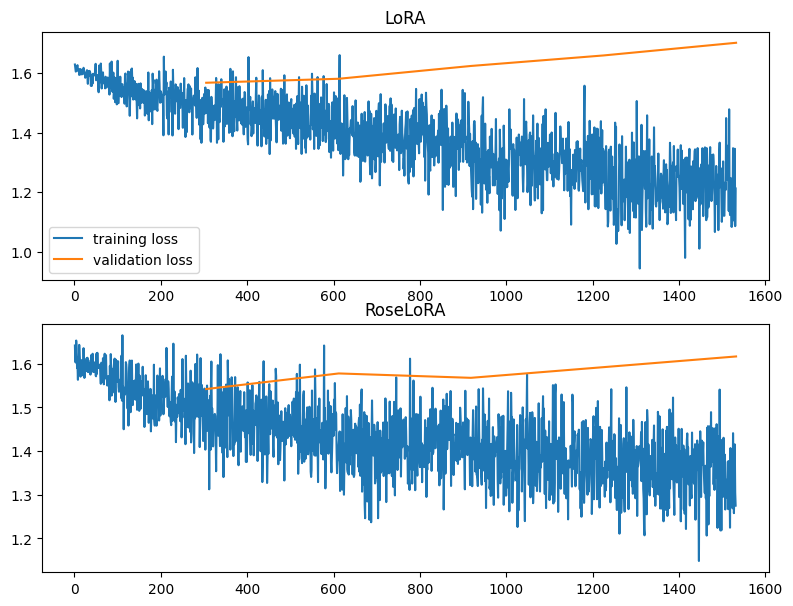

In [9]:
import matplotlib.pyplot as plt
metrics = pd.read_csv('logs/AQUA_roselora/baseline/metrics.csv')
metrics_base = pd.read_csv('logs/AQUA_lora/baseline/metrics.csv')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,figsize = (8,6))
fig.tight_layout() 
ax[0].plot(metrics_base['loss/train'][metrics_base['loss/train'].notna()], label = 'training loss')
ax[0].plot(metrics_base['loss/val'][metrics_base['loss/val'].notna()], label = 'validation loss')
ax[0].legend()
ax[0].set_title("LoRA")

ax[1].plot(metrics['loss/train'][metrics['loss/train'].notna()], label = 'training loss')
ax[1].plot(metrics['loss/val'][metrics['loss/val'].notna()], label = 'validation loss')
ax[1].set_title("RoseLoRA")
plt.savefig("Plots/Loss.png")
plt.show()

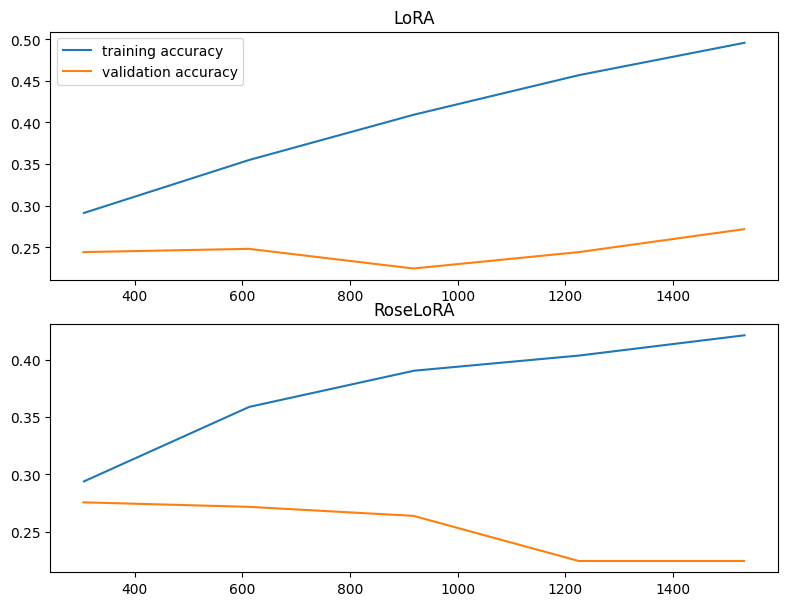

In [10]:
import matplotlib.pyplot as plt
metrics = pd.read_csv('logs/AQUA_roselora/baseline/metrics.csv')
metrics_base = pd.read_csv('logs/AQUA_lora/baseline/metrics.csv')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,figsize = (8,6))
fig.tight_layout() 
ax[0].plot(metrics_base['Acc/train'][metrics_base['Acc/train'].notna()], label = 'training accuracy')
ax[0].plot(metrics_base['Acc/val'][metrics_base['Acc/val'].notna()], label = 'validation accuracy')
ax[0].legend()
ax[0].set_title("LoRA")

ax[1].plot(metrics['Acc/train'][metrics['Acc/train'].notna()], label = 'training accuracy')
ax[1].plot(metrics['Acc/val'][metrics['Acc/val'].notna()], label = 'validation accuracy')
ax[1].set_title("RoseLoRA")
plt.savefig("Plots/Acc.png")
plt.show()